In [1]:
import pypangraph as pp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import defaultdict
from ete3 import Tree
from Bio import SeqIO

In [3]:
# reordering according to list of leaves from Newick tree
t = Tree("data/tsa56_tree.txt")
ordered_names = t.get_leaf_names()
print(ordered_names)
print(len(ordered_names))

['Orientia_chuto', 'ta686', 'tw22', 'wgot003', 'wgot013', 'kato', 'wgot001', 'wgot017', 'wgot007', 'ta763', 'gilliam', 'ikeda', 'boryong', 'karp', 'ut176', 'wgot020', 'wgot015', 'wgot031', 'ut76', 'tw1', 'wuj2014', 'wgot016', 'wgot005', 'wgot004', 'wgot008', 'wgot019']
26


In [4]:
def reorder_fasta(input_file, ordered_names, output_file="reordered_genomes.fasta"):
    # Read all sequences into a dictionary with lowercase keys
    sequences = {}
    for record in SeqIO.parse(input_file, "fasta"):
        # Get the identifier without any description and convert to lowercase
        identifier = record.id.split()[0].lower()
        sequences[identifier] = record

    # Create a list of records in the desired order
    ordered_records = []
    for name in ordered_names:
        name_lower = name.lower()
        if name_lower in sequences:
            ordered_records.append(sequences[name_lower])
        else:
            print(f"Warning: {name} not found in the input FASTA file")

    # Write the reordered sequences to a new file
    SeqIO.write(ordered_records, output_file, "fasta")
    print(f"Reordered sequences written to {output_file}")


In [5]:
reorder_fasta("data/whole_genomes_for_pangraph.fasta", ordered_names, output_file="data/tsa56_reordered_genomes.fasta")
reorder_fasta("data/IRs_for_pangraph.fasta", ordered_names, output_file="data/tsa56_reordered_IRs.fasta")

Reordered sequences written to tsa56_reordered_genomes.fasta
Reordered sequences written to data/tsa56_reordered_IRs.fasta


In [7]:
def plot_synteny(graph,figsize=(10,6),output_file="synteny_1"):
    path_dict = graph.to_path_dictionary()
    block_stats = graph.to_blockstats_df()
    # dictionary to assign a new random color to each block
    block_color = defaultdict(lambda: plt.cm.rainbow(np.random.rand()))

    fig, ax = plt.subplots(figsize=figsize)

    y = 0
    for path_name, path in path_dict.items():
        x = 0
        for block_id, block_strand in path:

            L = block_stats.loc[block_id, "len"] # block consensus length
            is_core = block_stats.loc[block_id, "core"]

            # block color
            color = block_color[block_id] if is_core else "lightgray"
            block_color[block_id] = mpl.colors.to_hex(color)

            height = 0.8 if is_core else 0.6 # block thickness

            ax.barh(y, L, left=x, height=height, color=color)

            x += L
        y += 1

    ax.set_yticks(range(len(path_dict)))
    ax.set_yticklabels(path_dict.keys())
    ax.set_xlabel("length (bp)")
    plt.savefig(f"output/{output_file}.pdf",format="pdf")
    plt.show()

def plot_MSU(graph,threshold_len,figsize=(8, 5),output_file_name="MSU_1"):
    MSU_mergers, MSU_paths, MSU_len = pp.minimal_synteny_units(graph, threshold_len)

    cmap = mpl.colormaps["rainbow"]
    color_generator = (cmap(i / len(MSU_len)) for i in range(len(MSU_len)))
    colors = defaultdict(lambda: next(color_generator))

    fig, ax = plt.subplots(figsize=figsize)

    for i, (iso, path) in enumerate(MSU_paths.items()):
        for j, node in enumerate(path.nodes):
            ax.barh(i, 1, left=j, color=colors[node.id])
            if not node.strand:
                ax.arrow(j + 1, i, -0.8, 0, head_width=0.2, head_length=0.2)

    ax.set_yticks(range(len(MSU_paths)))
    ax.set_yticklabels(list(MSU_paths.keys()))
    plt.title(f"Minimal block size = {threshold_len}bp")
    plt.savefig(f"output/{output_file_name}.pdf",format="pdf")
    plt.show()

In [8]:
graph = pp.Pangraph.from_json("data/Ot_pangraph_tsa56.json")
graph_IR = pp.Pangraph.from_json("data/Ot_IR_pangraph_tsa56.json")
print(graph)
print(graph_IR)

pangraph object with 17 paths, 6851 blocks and 138546 nodes
pangraph object with 17 paths, 1364 blocks and 8938 nodes


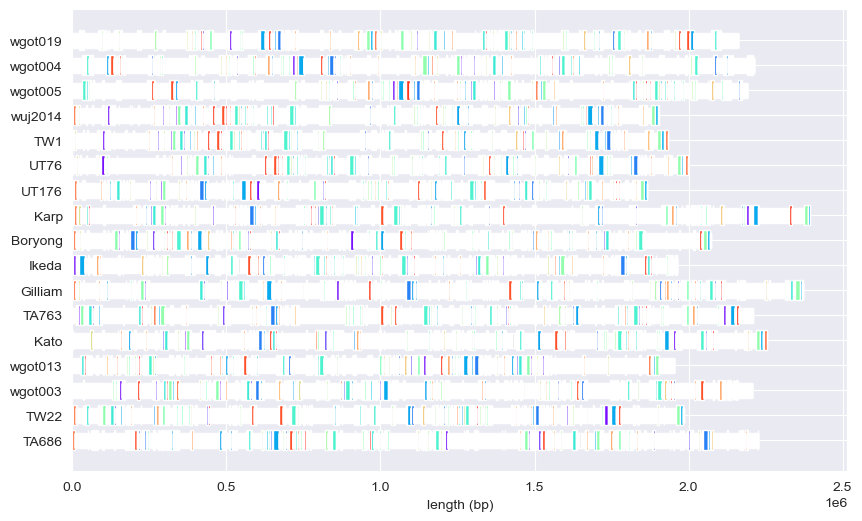

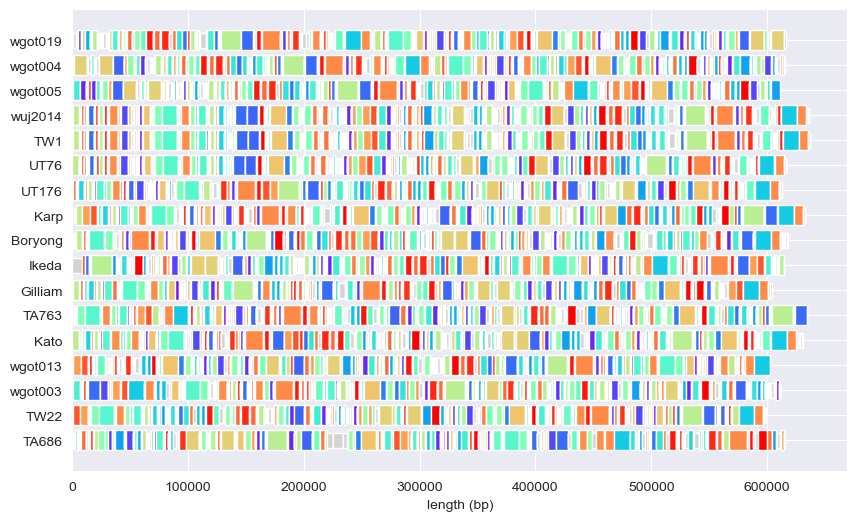

In [11]:
plot_synteny(graph,output_file="by_tsa56_synteny")
plot_synteny(graph_IR,output_file="by_tsa56_synteny_IR")


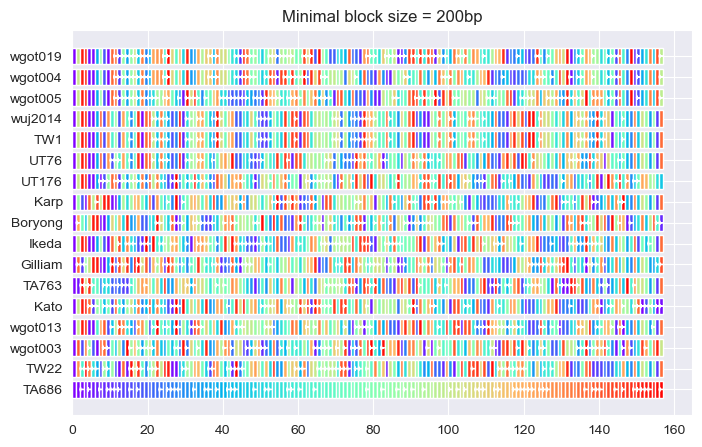

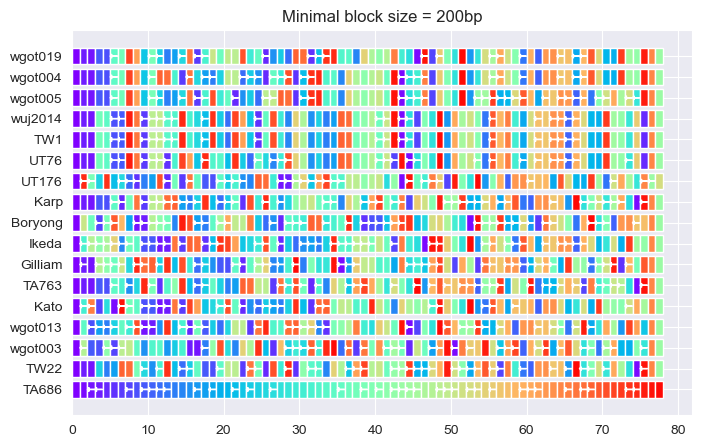

In [12]:
plot_MSU(graph=graph,threshold_len=200,output_file_name="MSU_core100_by_tsa56_min200")
plot_MSU(graph=graph_IR,threshold_len=200,output_file_name="MSU_IR_core100_by_tsa56_min200")